- import labeled data set
-- use all data, then take care about multiple similar looking images
- split into train / test sets
- train classifier
- test classifier

------------
ideas:
- train convnet on HOG features 
- train vanilly NN on hog_feature_vec

In [1]:
import numpy as np 
import glob
import cv2

def read_images(image_dir_list):    
    images = []
    
    for img_dir in image_dir_list:    
    
        # get all image files in the current directory
        img_file_list = glob.glob('./training_data/' + img_dir + '/?*.png')

        for img_file in img_file_list:
            img = cv2.imread(img_file)        
            images.append(img)
            #images.append(np.ravel(img))
    
    print('imported {} images'.format(len(images)))  
            
    return images         

In [133]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def get_hog_feature_map(img):
    pix_per_cell = 8
    cell_per_block = 2
    num_orientations = 9     

    features = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                   cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                   visualise=False, feature_vector=False)
    
#     if plot_result:
#         fig = plt.figure()
#         plt.subplot(121)
#         plt.imshow(img, cmap='gray')
#         plt.title('Example Car Image')
#         plt.subplot(122)
#         plt.imshow(hog_image, cmap='gray')
#         plt.title('HOG Visualization')
#         plt.show()
    
    return features

def get_hog_feature_vec(img):
    pix_per_cell = 8
    cell_per_block = 2
    num_orientations = 9     

    feature_vec = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                      visualise=False, feature_vector=True)

    return feature_vec

def plot_feature_vec(feature_vec):
    plt.bar(np.arange(0, len(feature_vec)), feature_vec)
    plt.show()
    
def normalize_vec(feature_vec):
    # Reshape the vector
    vector = feature_vec.reshape(-1, 1)
    # Create the scaler for normalization
    scaler = StandardScaler().fit(vector)
    # Apply the scaler 
    scaled_vec = scaler.transform(vector)
    
    return scaled_vec
        
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_hist_feature_vec_single_channel(img):
    
    n_cells = 3 # number of square cells the image gets dicided into (along each axis) 
    n_bins = 10 # number of histogram bins
    
    size = img.shape[0]    
    hist_features = []
    #feature_vec = np.zeros((n_cells*n_cells*n_bins))
    
    for ix in range(n_cells):
        for iy in range(n_cells):
            
            start_y = int(iy*size*1.0/n_cells)
            end_y = int((iy+1)*size*1.0/n_cells)
            
            start_x = int(ix*size*1.0/n_cells)
            end_x = int((ix+1)*size*1.0/n_cells)
            
            hist, bins = np.histogram(img[start_y:end_y, start_x:end_x].ravel(), n_bins, [0,256])
            
            hist_features.append(hist)
            #feature_vec[ix*iy*n_bins:ix*iy*n_bins+n_bins] = hist.ravel()
        
    feature_vec = np.array(hist_features).ravel()
    
    return feature_vec 

def get_hist_feature_vec(img):    

    img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 

    feature_vec_c1 = get_hist_feature_vec_single_channel(img_conv[:,:,0])
    feature_vec_c2 = get_hist_feature_vec_single_channel(img_conv[:,:,1])
    feature_vec_c3 = get_hist_feature_vec_single_channel(img_conv[:,:,2])

    hist_feature_vec = np.hstack((feature_vec_c1, feature_vec_c2, feature_vec_c3))
  
    return hist_feature_vec
    
def extract_features(images):
    features = []
    
    for img in images:        
        hist_feature_vec = get_hist_feature_vec(img)
        hist_feature_vec_norm = normalize_vec(hist_feature_vec)
        
        img_gray = convert_to_gray(img)
        hog_feature_vec = get_hog_feature_vec(img_gray)   
        hog_feature_vec_norm = normalize_vec(hog_feature_vec)
        
        feature_vec_combined = np.vstack((hist_feature_vec_norm, hog_feature_vec_norm))

        features.append(feature_vec_combined)
        
    return features


In [88]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
import pickle

def calculate_test_accuracy(classifier, features, labels):   
    
    pred = classifier.predict(features)
    num_correct = np.count_nonzero(pred == labels)
    acc = 1.0*num_correct/len(labels)
            
    return acc            

def create_classifier(vehicle_features, non_vehicle_features):

    # create input data 'X' from features
    X = np.vstack((vehicle_features, non_vehicle_features))
    X = X.reshape((X.shape[0], X.shape[1]))

    # create output labels 'y': 1=vehicle, 0=non-vehicle
    vehicle_labels = np.ones((len(vehicle_features)))
    non_vehicle_labels = np.zeros((len(non_vehicle_features)))
    y = np.hstack((vehicle_labels, non_vehicle_labels))

    # shuffle the data
    X, y = shuffle(X, y)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # train a SVM for classification by performing a grid search in parameter space
    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3, 5, 7, 9]} # best until now: {'C': 5, 'kernel': 'rbf'}
    parameters = {'C':[2,3,4]}
    svc = svm.SVC(kernel='linear')
    classifier = GridSearchCV(svc, parameters)
    classifier.fit(X_train, y_train)  

    print('finished training')
    print('best parameters: {}'.format(classifier.best_params_)) # {'C': 5, 'kernel': 'rbf'}
    
    acc = calculate_test_accuracy(classifier, X_test, y_test)
    print('test accuracy: {:.3f}'.format(acc))
    
    # save the classifier
    with open('classifier.pkl', 'wb') as fid:
        pickle.dump(classifier, fid)  
        print('saved classifier')
    
    return classifier


In [89]:
train_classifier = False

if train_classifier: # train a new classifier 

    # read vehicle images
    #vehicle_images = read_images(['vehicles/GTI_Far', 'vehicles/GTI_Left', 'vehicles/GTI_MiddleClose', 
    #                'vehicles/GTI_Right', 'vehicles/KITTI_extracted'])
    vehicle_images = read_images(['vehicles/KITTI_extracted'])
    
    # read non-vehicle images
    #non_vehicle_images = read_images(['non-vehicles/GTI', 'non-vehicles/Extras'])
    non_vehicle_images = read_images(['non-vehicles/Extras'])
    
    # extract features from images
    vehicle_features = extract_features(vehicle_images)  
    non_vehicle_features = extract_features(non_vehicle_images)  
    
    # train the classifier
    classifier = create_classifier(vehicle_features, non_vehicle_features) # test accuracy: 0.995 
    
else: # open a saved classifier
    
    with open('classifier.pkl', 'rb') as fid:
        classifier = pickle.load(fid)   
        print('loaded classifier')


imported 5966 images
imported 5068 images


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


finished training
best parameters: {'C': 2}
test accuracy: 0.996
saved classifier


In [90]:
import time

def start_timer():
    global _t_start
    _t_start = time.clock()

def get_avg_time(key):
    pass

In [134]:

def get_divisible_range(max_value, crop_percentage, divider):
    
    start = int(max_value*crop_percentage[0])
    end = int(max_value*crop_percentage[1])
    
    delta = end - start     
    delta = delta - (delta % divider)
    
    end = start + delta
    
    return start, end
    

def crop_image(img): #crop the image in a way that the height and width is divisible by 'pix_per_cell'
    
    y_crop_percentage = [0.5, 1.0]
    x_crop_percentage = [0.0, 1.0]
    
    pix_per_cell = 8
    
    y_start, y_end = get_divisible_range(img.shape[0], y_crop_percentage, pix_per_cell)
    x_start, x_end = get_divisible_range(img.shape[1], x_crop_percentage, pix_per_cell)
    
    img_cropped = img[y_start:y_end, x_start:x_end]
    
    return img_cropped

def draw_patches(img_input, patches):
    
    img = np.copy(img_input)
    
    for patch in patches:
        img = cv2.rectangle(img, (patch[0], patch[1]), (patch[2], patch[3]), (0,255,0), 2)
        
    return img
 

def get_patches(img, stride):
    
    pix_per_cell = 8 # same as for training the classifier
    cells_per_patch = 8 # same number as for training the classifier
    
    stride_x = stride # stride of 4 = 50% overlap
    stride_y = stride # stride of 4 = 50% overlap
    
    start_x = 0
    start_y = 0
    
    end_x = img.shape[1]
    end_y = img.shape[0]
    
    img_patches = []
    hog_patches = []   

    px = start_x
    py = start_y       

    qx = px + pix_per_cell*cells_per_patch 
    qy = py + pix_per_cell*cells_per_patch 

    while qx < end_x:           

        while qy < end_y:

            img_patches.append((px, py, qx, qy)) 
            hog_patches.append((int(1.0*px/cells_per_patch), 
                                int(1.0*py/cells_per_patch), 
                                int(1.0*qx/cells_per_patch), 
                                int(1.0*qy/cells_per_patch)))

            py += stride_y*pix_per_cell                
            qy = py + pix_per_cell*cells_per_patch 

        px += stride_x*pix_per_cell
        qx = px + pix_per_cell*cells_per_patch   

        py = start_y   
        qy = py + pix_per_cell*cells_per_patch 
            
    return img_patches, hog_patches   
   

def get_sliding_window_features(img_orig):
    
    global classifier
    #size_levels = [1, 2, 3, 4, 5]
    #size_levels = [2, 2.5, 3, 3.5, 4]
    #size_levels = [1]
    size_levels = [1.5, 2, 2.5]
    
    pix_per_cell = 8
    
    heat_map = np.zeros((img_orig.shape[0], img_orig.shape[1]))
    
    for size_level in size_levels:
        img = cv2.resize(img_orig, None, fx=1.0/size_level, fy=1.0/size_level)
        hog_map = get_hog_feature_map(convert_to_gray(img))

        stride = 1
        img_patches, hog_patches = get_patches(img, stride)
        
        #hist_feature_vec = get_hist_feature_vec(img)
        #hist_feature_vec_norm = normalize_vec(hist_feature_vec) 
            
        t_start = time.clock()
        for img_patch, hog_patch in zip(img_patches, hog_patches):

            current_image = img[img_patch[1]:img_patch[3], img_patch[0]:img_patch[2]]            
            
            hist_feature_vec = get_hist_feature_vec(current_image)
            hist_feature_vec_norm = normalize_vec(hist_feature_vec)              
            
            current_hog_vec = hog_map[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()
            hog_feature_vec_norm = normalize_vec(current_hog_vec)
            
            feature_vec_combined = np.vstack((hist_feature_vec_norm, hog_feature_vec_norm))
            
            pred = int(classifier.predict(feature_vec_combined.reshape(1, -1)))
           
           
            if pred == 1:
                print('vehicle detected, level = {}'.format(size_level))

                #plt.figure(figsize=(4,4))
                #plt.imshow(current_image, cmap='gray')
                #plt.show()

                heat_map[size_level*img_patch[1]:size_level*img_patch[3], 
                         size_level*img_patch[0]:size_level*img_patch[2]] += 1


    return heat_map
          

In [135]:
img = cv2.imread('./test_images/test6.jpg')

img = crop_image(img)

t_start = time.clock()
heat_map = get_sliding_window_features(img)
print(time.clock()-t_start)


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:130: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 1.5
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2
vehicle detected, level = 2.5
25.513813215511618


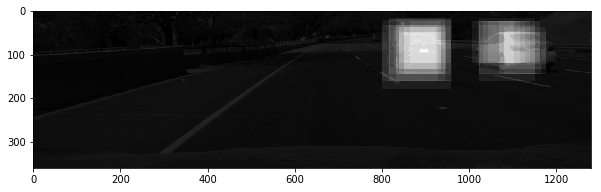

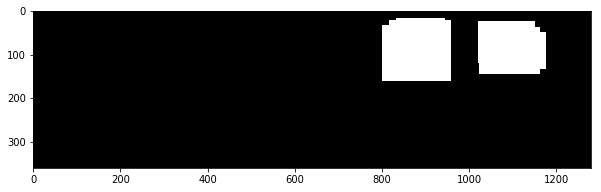

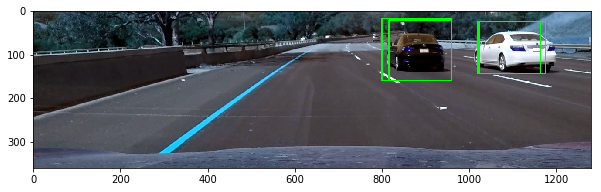

In [137]:
from scipy.ndimage.measurements import label

def draw_rectangle(img, p1, p2):
    return cv2.rectangle(img, p1, p2, (0,255,0), 2)


img_gray = convert_to_gray(img)
res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map, 80.0, 0)

plt.figure(figsize=(10,8))
plt.imshow(res, cmap='gray')
plt.show()


heat_map_thresh = np.zeros_like(heat_map)
heat_map_thresh[heat_map >= 2] = 1

plt.figure(figsize=(10,8))
plt.imshow(heat_map_thresh, cmap='gray')
plt.show()


labeled_array, num_features = label(heat_map_thresh)

for i in range(num_features):
    x_ind, y_ind = np.nonzero(labeled_array == i+1)
    #x_min = np.min(x_ind)
    #y_min = np.min(y_ind)
    #print(x_min, y_min)
    draw_rectangle(img, (np.min(y_ind), np.min(x_ind)), (np.max(y_ind), np.max(x_ind)
                                                        ))

plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.show()




In [ ]:
#img = cv2.imread('./test_images/6.png')
img = cv2.imread('./test_image.jpg')
#img = crop_image(img)

#img_patches, hog_patches = get_patches(img)
#img = draw_patches(img, img_patches)

plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

#print(hog_patches)

